# Mapping urban tree extent
Urban green spaces, particularly urban trees, play a vital role in enhancing the quality of life in cities by providing ecosystem services such as air purification, temperature regulation, and recreational spaces for residents. Accurate mapping and monitoring of urban tree extent are essential for urban planners and environmental managers to ensure sustainable urban development. Mapping urban tree cover enables the analysis of their potential as nature-based solutions to mitigate extreme heat, as [illustrated here](https://www.mapping-africa-transformations.org/green-spaces-nbs-heat-waves/).

This work is part of a collaborative initiative between **Digital Earth Africa** and the **OECD Sahel and West Africa Club (SWAC)** to advance tools and methodologies for urban sustainability in Africa. By leveraging satellite imagery from Sentinel-2, this partnership aims to provide robust, data-driven insights for mapping and monitoring urban vegetation across African cities. Satellite imagery, particularly from high-resolution sensors like Sentinel-2, offers a valuable tool for mapping and monitoring vegetation in urban areas. Sentinel-2 provides multispectral data with a resolution that is suitable for detecting and analyzing urban trees at a city-wide scale. This data, combined with advanced classification techniques, can help in the accurate delineation of urban green spaces.

This notebook complements the work done by OECD/SWAC, which provides urban agglomerations (for 2015 and 2020) along with green space indicators, based on the ESA WorldCover datasets for 2020 and 2021, through the [Africapolis dataset](https://docs.digitalearthafrica.org/en/latest/data_specs/Africapolis_urban_specs.html). This analysis builds on that by providing a more detailed method for mapping and monitoring urban tree extent using Sentinel-2 data, offering deeper insights into urban vegetation over time. By incorporating time series analysis, we assess changes in tree cover across urban agglomerations, contributing to the overall understanding of urban sustainability.

In this notebook, we implement an algorithm for mapping urban tree extent using the [Digital Earth Africa Sentinel-2 Annual GeoMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html), incorporating time series analysis to assess changes in tree cover over multiple years. 

### Description
This notebook demostrates how to load and visualise urban tree extent.
The notebook covers:

1. **Define the area of interest (AOI)**: The default method computes urban tree extent for the area of interest (AOI) that you define. This AOI is used to select urban agglomerations from the [Africapolis dataset](https://docs.digitalearthafrica.org/en/latest/data_specs/Africapolis_urban_specs.html). However, if you do not wish to use an agglomeration and prefer to proceed only with the AOI you defined, you can comment out cells 4-7. This will allow you to work exclusively with your specified area without selecting any agglomerations.
2. **Load Sentinel-2 GeoMAD Data**: Retrieve and load Sentinel-2 Annual GeoMAD data covering the area of interest.
3. **Compute NDVI**: Calculate the Normalized Difference Vegetation Index (NDVI) to highlight areas with healthy vegetation that are likely to contain trees.
4. **Apply Otsu Thresholding for Tree Detection**: Use multi-level Otsu thresholding on NDVI values to segment urban trees from other types of vegetation cover.
5. **Calculate Tree Area**: Compute the total tree-covered area in square kilometers by counting the number of pixels classified as trees over time.
6. **Time Series Plot**: Plot a time series showing the total tree area covered over time to analyse trends and changes in tree cover across the study period.



### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import rioxarray 
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from datacube.utils.geometry import Geometry
from skimage.filters import threshold_multiotsu

from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from deafrica_tools.load_africapolis import get_africapolis

### Connect to the datacube
Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="OECD_SWAC_Urban_tree_extent")

### Upload or select urban agglomeration(s)
The following cell allows you to define the area of interest for the urban tree extent analysis.
#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer, or separate latitude and longitude buffers, this method allows you to define an area of interest around a central point. You can input the central latitude, central longitude, and a buffer value in degrees to create a square area around the center point. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates `(10.338, -1.055)`. 
    
    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.
    
    For reasonable loading times, set the buffer as `0.1` or lower.

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.


***This area of interest (AOI) can be directly used for conducting urban tree extent analysis, however, in the next cells, you will see how this same AOI can serve as a starting point to select urban agglomerations from the Africapolis dataset if you prefer to work with a specific agglomeration instead. Note that the lines of code for selecting from Africapolis (lines 4-7) are included by default. If you do not wish to use an agglomeration and prefer to work solely with the AOI you defined, simply comment out lines 4-7 by adding the ``#`` symbol at the beginning of each of these lines.***

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=-4.3615, lon=15.3088, buffer=0.05)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

display_map(lon_range, lat_range)

### Alternative: Select AFRICAPOLIS urban agglomeration polygons within the area of interest
If you prefer to work with an urban agglomeration from the AFRICAPOLIS dataset instead of using the previously defined AOI, the code below provides this alternative. It will load the agglomerations within the AOI defined above. 

If you prefer to work with an urban agglomeration from the AFRICAPOLIS dataset instead of using the default area of interest (AOI), you can use the code below to load agglomerations within the AOI.

By default, the code selects agglomerations from the Africapolis dataset within the AOI. However, if you do not wish to use the agglomeration, you can opt to work with the AOI you defined earlier. To switch to this alternative, simply comment out lines 4-7, which are responsible for loading the Africapolis data and selecting the agglomeration, by adding a ``#`` symbol at the beginning of these lines.

This will allow you to either proceed with an agglomeration-based analysis or stick with the original AOI you defined.

In the following steps, we will select the Kinshasa agglomeration from the [Africapolis dataset](https://docs.digitalearthafrica.org/en/latest/data_specs/Africapolis_urban_specs.html) for our analysis.

In [4]:
# Create a bounding box from study area coordinates
bbox = (lon_range[0], lat_range[0], lon_range[1], lat_range[1])

# Load Africapolis data. 
agglomerations = get_africapolis(bbox=bbox, layer='Africapolis_2020')

# Print list of urban agglomerations and their green urban green space indicators
agglomerations.head()

id  agglosID   agglosName ISO3  Pop2020  \
0  Africapolis_2020.2158      2158  Brazzaville  COG  2031742   
1  Africapolis_2020.4858      4858     Kinshasa  COD  9850000   

   p_Urban_green_space_WC2020  p_Tree_cover_WC2020  \
0                        43.5                 13.5   
1                        41.0                 17.6   

   p_Urban_green_space_WC2021  p_Tree_cover_WC2021  Longitude  Latitude  \
0                        45.8                 19.5  15.245336 -4.220031   
1                        40.6                 20.2  15.296038 -4.410428   

  color_HEX                                           geometry  
0   #f1b78c  MULTIPOLYGON (((15.23080 -4.31030, 15.23100 -4...  
1   #f8dca0  MULTIPOLYGON (((15.22860 -4.33330, 15.22860 -4...

In [5]:
# Explore the urban agglomeration polygons located within the bounding box in an interactive map
agglomerations.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                attr='http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}')

In [6]:
# Edit the name below to select the area of interest
region_name = "Kinshasa"
geopolygon_gdf = agglomerations[agglomerations["agglosName"] == region_name]

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Explore the urban agglomeration polygons located within the bounding box
geopolygon_gdf.explore(tiles="https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
                attr='http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}')

## Calculate urban tree extent within the Urban Agglomeration
#### Load Sentinel-2 Annual GeoMAD data using `dc.load()`

The parameters for querying Sentinel-2 Annual GeoMAD data are defined to extract information specific to the selected urban agglomeration. Only the four bands—`red`, `green`, `blue`, and `near-infrared (nir)`—are selected because they are essential for both RGB plotting and NDVI calculation. The visual RGB bands (`red`, `green`, and `blue`) are used for visual representation of the urban area, while the `nir` band is crucial for calculating NDVI, a key vegetation index used to assess the presence and density of vegetation, such as urban trees.

In [7]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-10, 10),
    'output_crs':'EPSG:6933',
    'time': ('2017', '2022'),
}

#load Sentinel 2 data
ds = dc.load(product=['gm_s2_annual'],
             measurements=['red', 'green', 'blue', 'nir'],
             **query)

print(ds)

<xarray.Dataset> Size: 546MB
Dimensions:      (time: 6, y: 2899, x: 3920)
Coordinates:
  * time         (time) datetime64[ns] 48B 2017-07-02T11:59:59.999999 ... 202...
  * y            (y) float64 23kB -5.476e+05 -5.476e+05 ... -5.766e+05
  * x            (x) float64 31kB 1.463e+06 1.463e+06 ... 1.502e+06 1.502e+06
    spatial_ref  int32 4B 6933
Data variables:
    red          (time, y, x) uint16 136MB 1200 1228 1157 1089 ... 347 336 347
    green        (time, y, x) uint16 136MB 1207 1237 1189 1157 ... 642 588 566
    blue         (time, y, x) uint16 136MB 1024 1062 1029 992 ... 361 351 356
    nir          (time, y, x) uint16 136MB 2546 2587 2626 ... 3262 3323 3498
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


#### Clip the datasets to the shape of the area of interest
A geopolygon represents the bounds and not the actual shape because it is designed to represent the extent of the geographic feature being mapped, rather than the exact shape. In other words, the geopolygon is used to define the outer boundary of the area of interest, rather than the internal features and characteristics.

Clipping the data to the exact shape of the area of interest is important because it helps ensure that the data being used is relevant to the specific study area of interest. While a geopolygon provides information about the boundary of the geographic feature being represented, it does not necessarily reflect the exact shape or extent of the area of interest.

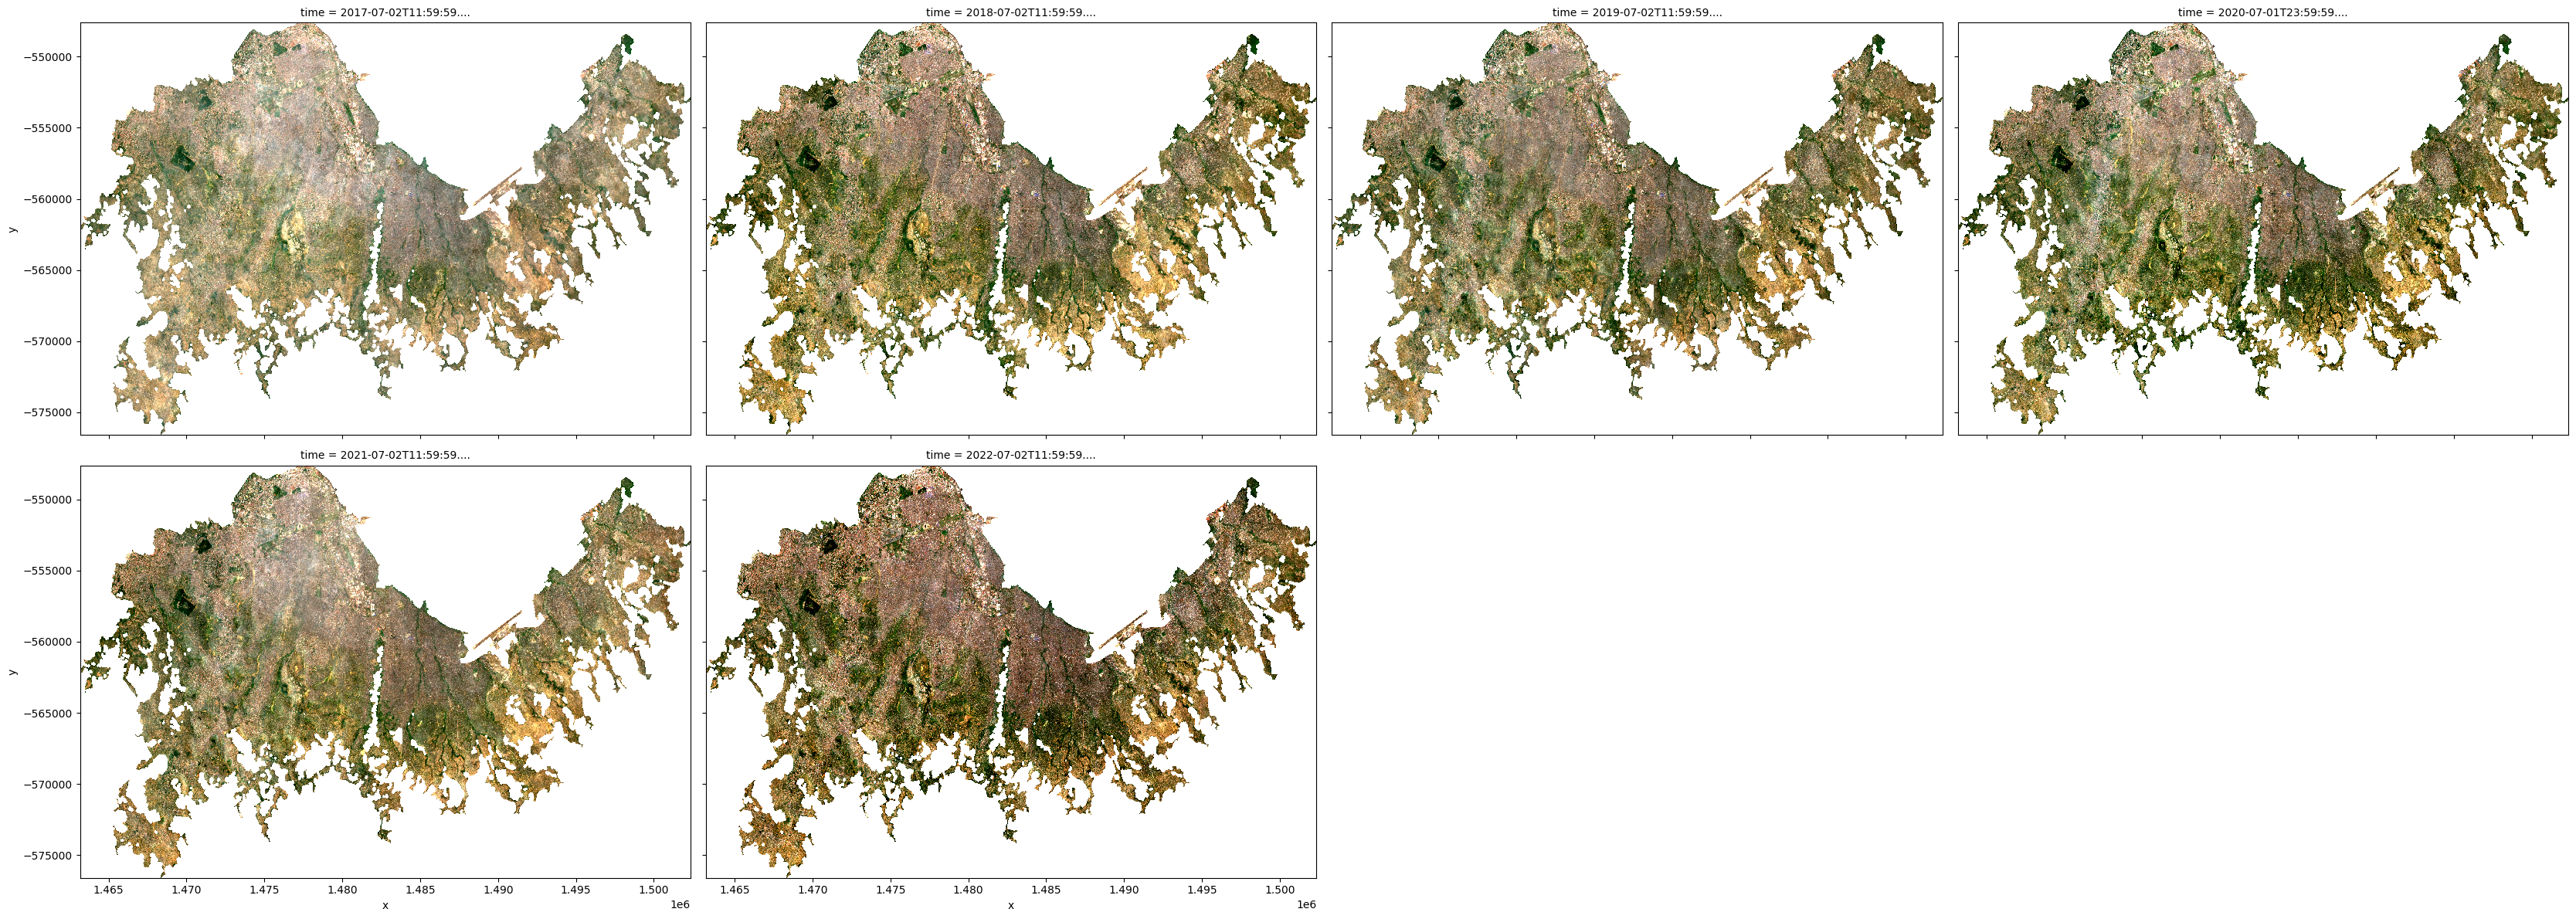

In [8]:
#Rasterise the area of interest polygon
aoi_raster = xr_rasterize(gdf=geopolygon_gdf, da=ds, crs=ds.crs)
#Mask the dataset to the rasterised area of interest
ds = ds.where(aoi_raster == 1)
# Plot the RGB
rgb(ds, col="time")

#### Calculate NDVI
The NDVI (Normalized Difference Vegetation Index) is calculated to assess vegetation health and density. NDVI is a widely used vegetation index that quantifies the difference between near-infrared (NIR) and red light reflected by vegetation. This difference is normalized to reduce atmospheric and sensor-related variations. The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

NDVI values range from -1 to 1, where higher values (close to 1) indicate healthy, dense vegetation, and lower values (close to -1) indicate non-vegetated surfaces.

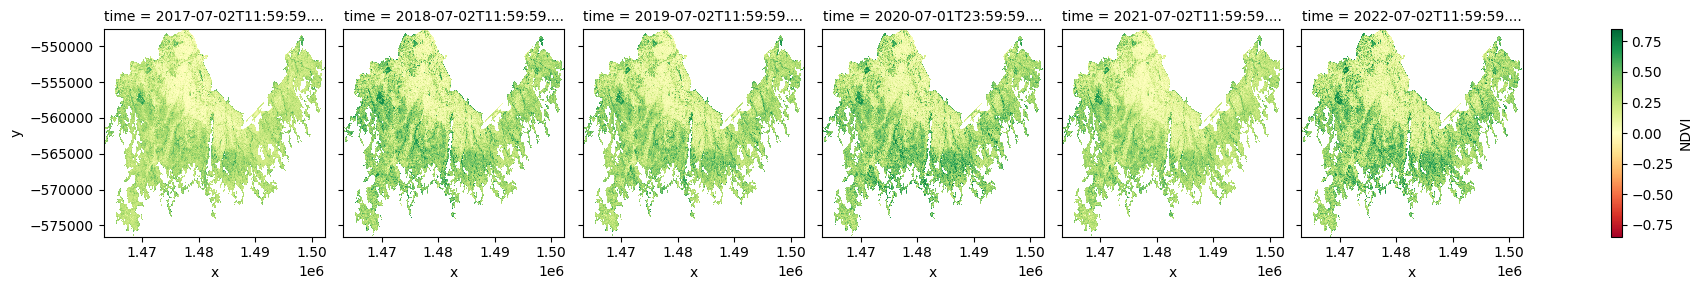

In [9]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index='NDVI', satellite_mission='s2', drop=False)
ds.NDVI.plot(cmap='RdYlGn', col="time")

#### Determine NDVI threshold for vegetation classification
The lower NDVI threshold for vegetation was found by analysing the distribution of NDVI values in the image that was mapped. The assumption was that pixels with an NDVI less than the median minus the distance from the median to the 95-percentile of the distribution were non-vegetation pixels (e.g. buildings, roads or lakes found in forests) ([Ottosen et al. 2020](https://www.sciencedirect.com/science/article/pii/S0303243419306087)). This initial NDVI threshold helps in distinguishing areas with significant vegetation, including grassland, shrubland, and trees. To specifically differentiate urban trees from other types of vegetation, subsequent Otsu thresholding is applied later. This method refines the classification to distinguish tree-covered areas from other vegetation types.

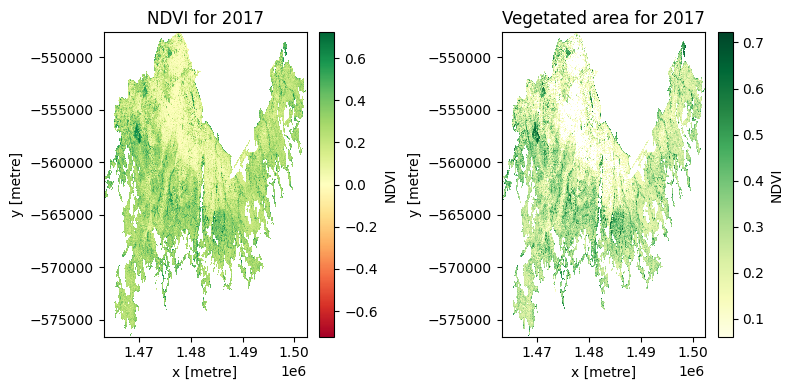

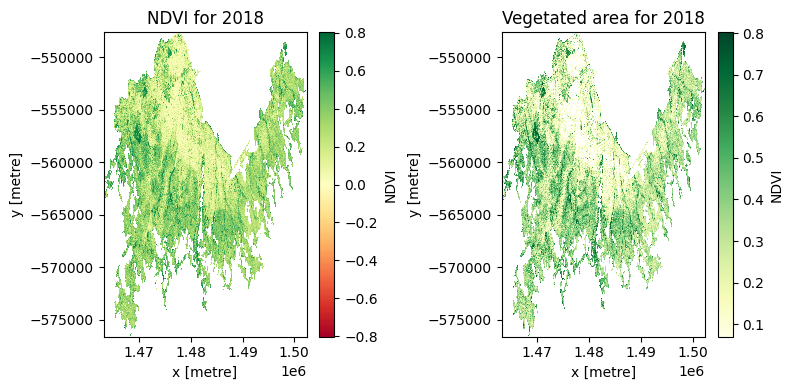

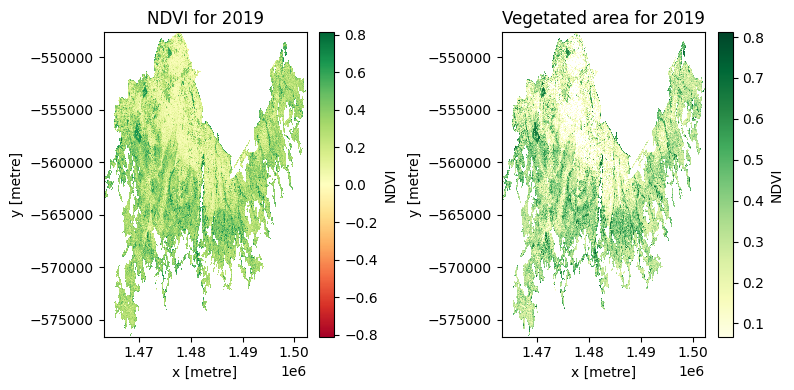

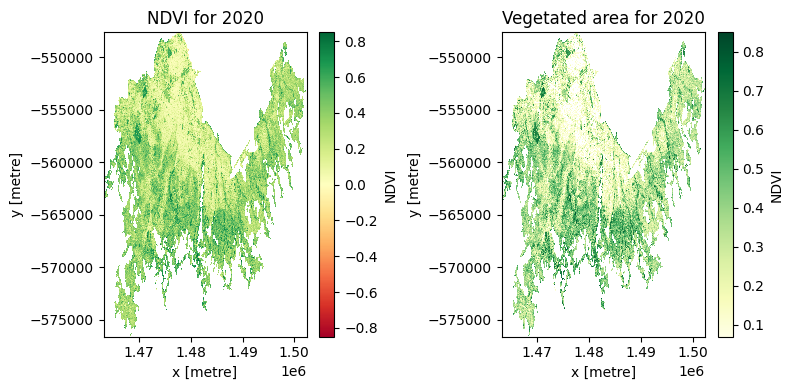

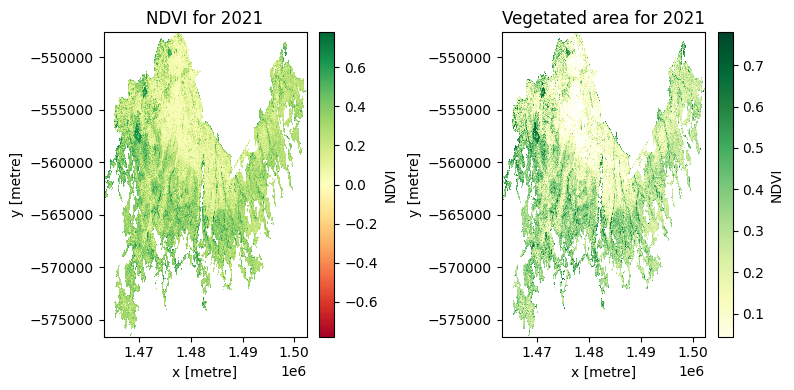

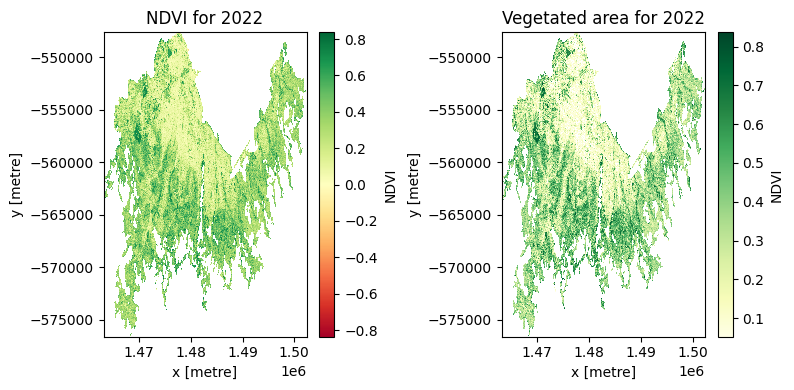

In [10]:
# Loop through each time step
for time_step in ds.time:
    # Select data for the current time step
    ds_time = ds.sel(time=time_step)

    # Compute NDVI statistics for the current time step
    ndvi_median = ds_time.NDVI.median(dim=['x', 'y']).values
    ndvi_95th = np.nanpercentile(ds_time.NDVI.values, 95)

    # Determine the NDVI threshold for the current time step
    ndvi_threshold = (ndvi_median - (ndvi_95th - ndvi_median)).item()

    # Apply the NDVI threshold and mask out non-tree areas
    tree_extent = ds_time.NDVI.where(ds_time.NDVI > ndvi_threshold)
    
    # Plot NDVI for the current time step with thresholded tree extent
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    ds_time.NDVI.plot(ax=axes[0], cmap='RdYlGn')
    tree_extent.plot(ax=axes[1], cmap='YlGn')
    
    # Add titles to each subplot
    axes[0].set_title(f'NDVI for {pd.to_datetime(time_step.values).year}')
    axes[1].set_title(f'Vegetated area for {pd.to_datetime(time_step.values).year}')
    
    plt.tight_layout()
    plt.show()


#### Otsu thresholding for tree detection
To specifically differentiate urban trees from other types of vegetation, multi-level Otsu’s method is applied to the NDVI values. Otsu's method is a statistical technique that automatically determines optimal threshold values for classifying pixel intensities into multiple distinct categories. This approach is ideal for segmenting vegetation into different density classes based on NDVI, which ranges from -1 to 1, where higher values indicate more vegetation.

A histogram of the NDVI values is generated, and the method determines two threshold levels, each represented by vertical red dashed lines. These thresholds divide the NDVI data into three categories:

* Low Vegetation: Areas with minimal vegetation, such as urban infrastructure or barren land.
* Moderate Vegetation: Areas with intermediate vegetation density, including shrubland and grassland.
* High Vegetation: Areas with dense vegetation, specifically targeting tree cover, which is the primary focus of urban tree mapping.

By separating NDVI values into these categories, this method improves the accuracy of identifying tree-covered areas, distinguishing them from grassland or shrubland, thus refining the overall analysis of urban green spaces.

The urban tree extent is visualized by applying the Otsu threshold to the NDVI data. Specifically, the NDVI values that exceed the second Otsu threshold (``otsu_thresholds[1]``) are selected to represent areas with high vegetation density, which are likely to be urban trees.

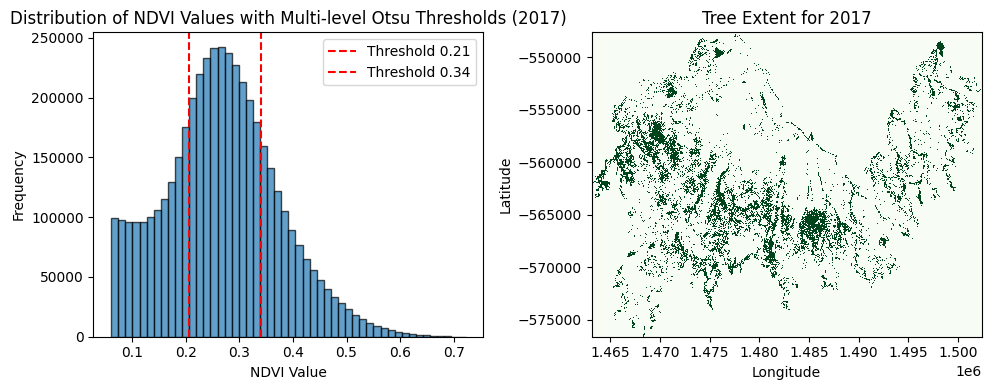

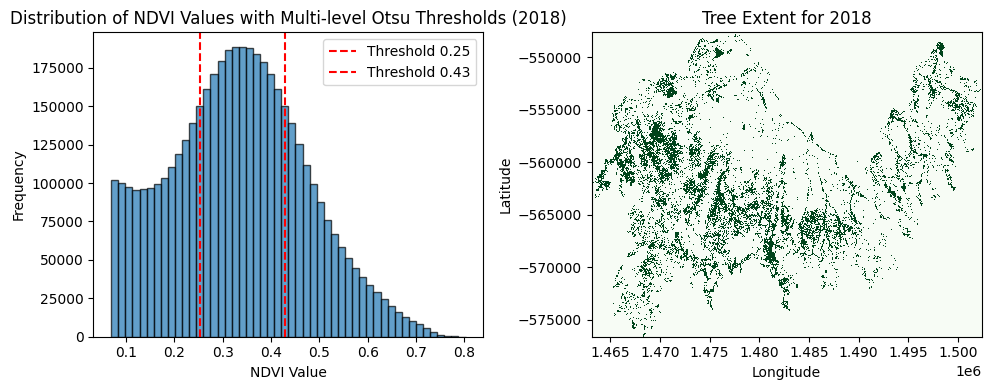

In [ ]:
# Prepare a list to store tree area data
tree_area_data = []

# Loop through each time step
for time_step in ds.time:
    # Select data for the current time step
    ds_time = ds.sel(time=time_step)

    # Compute NDVI statistics for the current time step
    ndvi_median = ds_time.NDVI.median(dim=['x', 'y']).values
    ndvi_95th = np.nanpercentile(ds_time.NDVI.values, 95)

    # Determine the NDVI threshold for the current time step
    ndvi_threshold = (ndvi_median - (ndvi_95th - ndvi_median)).item()

    # Filter NDVI values above the threshold and flatten them
    ndvi_values = ds_time.NDVI.where(ds_time.NDVI > ndvi_threshold).values.flatten()
    remaining_ndvi = ndvi_values[~np.isnan(ndvi_values)]  # Exclude NaN values

    # Compute multi-level Otsu thresholds
    otsu_thresholds = threshold_multiotsu(remaining_ndvi, classes=3)

    # Create a binary mask for tree extent using the second Otsu threshold
    tree_extent = ds_time.NDVI > otsu_thresholds[1]

    # Calculate the total area covered by trees for the current time step
    # Get the spatial resolution (pixel size) in meters
    resolution_x, resolution_y = ds_time.rio.resolution()  # May return negative values, take the absolute value
    pixel_area_m2 = abs(resolution_x * resolution_y)  # Calculate the pixel area in square meters
    pixel_area_km2 = pixel_area_m2 / 1_000_000  # Convert to square kilometers

    # Count the number of pixels classified as trees
    tree_pixels = np.sum(tree_extent)

    # Calculate the total area covered by trees in km²
    tree_area_km2 = tree_pixels * pixel_area_km2
    
    # Append the result to the list with the corresponding time step
    tree_area_data.append({'date': pd.to_datetime(time_step.values).year, 'tree_area_km2': tree_area_km2})

    # Plot the histogram and tree extent as before
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot histogram of NDVI values
    axes[0].hist(remaining_ndvi, bins=50, edgecolor='k', alpha=0.7)
    for threshold in otsu_thresholds:
        axes[0].axvline(threshold, color='r', linestyle='--', label=f'Threshold {threshold:.2f}')
    axes[0].set_xlabel('NDVI Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Distribution of NDVI Values with Multi-level Otsu Thresholds ({pd.to_datetime(time_step.values).year})')
    axes[0].legend()

    # Plot the tree extent
    tree_extent.plot(ax=axes[1], cmap='Greens', add_colorbar=False)
    axes[1].set_title(f'Tree Extent for {pd.to_datetime(time_step.values).year}')
    axes[1].set_xlabel('Longitude')
    axes[1].set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

### Calculate and analyze tree cover area
Determines the amount of land covered by trees within the area of interest, providing insights into the extent of tree cover and its proportion relative to the overall area of interest.

In [ ]:
# Convert the list of results into a DataFrame for easier analysis
tree_area_df = pd.DataFrame(tree_area_data)

# Now you can visualize the time series of tree area
plt.figure(figsize=(10, 5))
plt.plot(tree_area_df['date'], tree_area_df['tree_area_km2'], marker='o')
plt.title('Time series of tree area covered (km²)')
plt.xlabel('Date')
plt.ylabel('Area covered by trees (km²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')